

<div class="alert alert-block alert-info" style="width:400px, text-color:black"> 
For this task we will use  the <a href="https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv?select=age_gender.csv">age-gender-and-ethnicity-face dataset</a> which contains a number of images, each accompanied with features recording the age,  gender,  and ethnicity of the person in the image. This is a  version of the <a href="https://susanqq.github.io/UTKFace/" > UTKface dataset</a>, modified to make it easer to load as one file.<br>
Please note that
    <ul>
        <li>It happens not contain any people who self-identified as non-binary. So gender is labelled as 0 (male) or 1 (female)</li>
        <li> Ethicity is coded as an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern) <br> not my choice of language - terms from original site.</li>
          <li>  Each row of this version of the dataset contains integer values for the three features, a string with the name or the original jpg from the UTK archive, and a feature called 'pixels' which contains the 48x48 pixels values as a string.</li>
    </ul>

After some preliminaries, the next two cells load the data into a pandas dataframe and then shpw the first ten lines.

In [1]:
import numpy as np 
import pandas as pd
import os
import socket
import random
from matplotlib import pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as keras_layers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
tf.get_logger().setLevel('ERROR')


2025-02-10 20:40:53.765786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Some constants to keep experiments the same

In [2]:
batchsize=50
max_epochs=100
num_imgs=1000
patience=5

## Define useful method to plot training history and confusion matrix

In [3]:
def report(history,y_pred,y_true):
    plt.plot(history.epoch, history.history["accuracy"],history.history['val_accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.suptitle('Training (blue) and validation (orange) History')
    plt.show()
    
    predicted= np.argmax(y_pred,axis=1)
    actual = np.argmax(y_true,axis=1)
    print(f'Test Accuracy {(predicted==actual).sum() *100/len(actual)}%')
    cm=ConfusionMatrixDisplay.from_predictions(actual,predicted,display_labels=['male','female']) 


# Get the face data

In [4]:
if (socket.gethostname()=='csctcloud'): #on csctcloud
    datapath="/home/common/datasets"
elif (socket.gethostname()[0:7]=='jupyter'): #on csctcloud
    datapath="~/shared/datasets"
else: #machine specific- this is for jim's development
    datapath = "../datasets"
dataframe = pd.read_csv(datapath+'/utk/teacher_pupil.csv')
dataframe.head()
print(dataframe.columns)

Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels', 'label'], dtype='object')


### Let's start by splitting the images into appropriate numpy arrays
- We first convert the 'pixels' column of the dataframe into a numpy array
- then split each row into a sub-array using a space as a seperator, 
- before reshaping our array from 23705x2304 floats into 23705 * (48x48) images
- the conversion of the labels is first makes a straightforward 1d array, 
  then uses that to put 1s into the right column of a 2d array for one-hot encoding 

In [5]:
imgs = dataframe['pixels'].to_numpy()
print(f'original shape of imgs array {imgs.shape}')
imgs = np.array([x.split(' ') for x in imgs], dtype=float)
print(f' shape  after splitting: {imgs.shape}')
imgs = imgs.reshape(-1,48,48,1).astype(int)
print(f'shape  after reshaping into 2d images with one channel: {imgs.shape}')

original shape of imgs array (23705,)
 shape  after splitting: (23705, 2304)
shape  after reshaping into 2d images with one channel: (23705, 48, 48, 1)


In [6]:
labels= dataframe['gender'].to_numpy()
y = to_categorical(labels,num_classes=2)
print(f'shape of labels is {labels.shape} and y is {y.shape}')
print(f'Split of males:females in the labels is {np.unique(labels,return_counts=True)[1]}')

shape of labels is (23705,) and y is (23705, 2)
Split of males:females in the labels is [12391 11314]


### delete the original dataframe to save memory
del dataframe

### This is what ten randomly chosen images look like

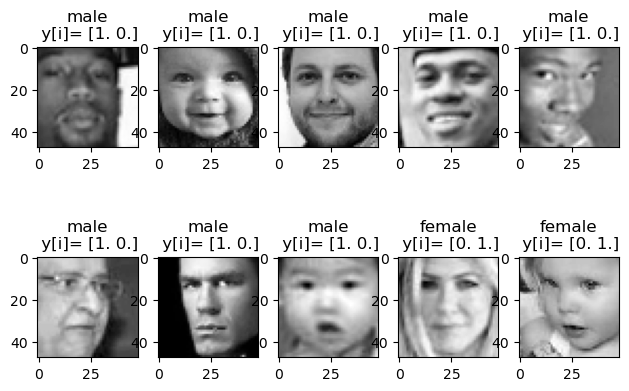

In [7]:
fig,axs=plt.subplots(2,5,figsize=(7.5,5))
for i in range(10):
    img = random.randint(0,labels.shape[0])
    axs[i//5][i%5].imshow(imgs[img].reshape(48,48),cmap='gray')
    axs[i//5][i%5].set_title(f'{ "male" if labels[img]==0 else "female"}\n y[i]= {y[img]}')
                                   

### Finally use standard sklearn function to split data into training and test set

**Note** the use of the stratify option to preserve (roughly) even distribution of males:females in train and test sets

In [8]:

X_train,X_test,y_train,y_test= train_test_split(imgs,y,test_size=7705,shuffle=True,stratify=y)
print('For sanity-checking: train and test arrays have shapes '
      f'{X_train.shape}, {X_test.shape}, '
      f'{y_train.shape},{y_test.shape}'
     )

For sanity-checking: train and test arrays have shapes (16000, 48, 48, 1), (7705, 48, 48, 1), (16000, 2),(7705, 2)


## Now the convnet bit
- start by specifying  a function to create a straightforward CNN using keras sequential model interface
- then make a model and train it

The architecture is inspired by [this kaggle post](https://www.kaggle.com/code/amishaasrani/gender-detection-by-cnn).  
It optionally introduces some new types of layer into each convolution-maxpooling block, which implement some standard tricks to improve deep networks training.
1. *Batch normalisation* is a method that attempts to reduce the random effects of dividing the data into batches.  
   - It works by scaling the outputs from each batch of data so they lie roughly within constant bounds  
   estimated as the mean of the training data +/- the std. deviation of the training data.  
   - The net effect is usually to make it **faster to train** a network.  
   - [keras documentation here](https://keras.io/api/layers/normalization_layers/batch_normalization/)  
   - [Machine Learning Mastery blog here](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
2. *Dropout* is a **regularisation** technique applied to try and reduce the number of variables (non-zero weights) in the learned model.  
   It works  by effectively pruning connections.  
   - During training a fraction (0.2 in this case) of the nodes are arbitrarily 'switched off' for each batch,  
     so that the back-propagation can then reduce weights that do not seem to have any effect. 
   - The net effect is usually **to help prevent over-fitting**. 
   - [keras documentation here](https://keras.io/api/layers/regularization_layers/dropout/)  
   - [Machine Learning Mastery blog here](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)

In [10]:
def conv_model(num_classes,use_dropout=False,use_batch_norm=False):
    model = Sequential()
    
    #first block of layers
    model.add(keras_layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    if use_batch_norm:
        model.add(keras_layers.BatchNormalization())
    model.add(keras_layers.MaxPool2D(pool_size=(2,2)))
    if use_dropout:
        model.add(keras_layers.Dropout(0.2))
    
    #second block of layers
    model.add(keras_layers.Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    if use_batch_norm:
        model.add(keras_layers.BatchNormalization())
    model.add(keras_layers.MaxPool2D(pool_size=(2,2)))
    if use_dropout:
        model.add(keras_layers.Dropout(0.2))
    
    #third block of layers
    model.add(keras_layers.Conv2D(64, kernel_size=(3,3),activation="relu",padding="same"))
    if use_batch_norm:
        model.add(keras_layers.BatchNormalization())
    model.add(keras_layers.MaxPool2D(pool_size=(2,2)))
    if use_dropout:
        model.add(keras_layers.Dropout(0.2))
    
    #fully connected layers followed by softmax output
    model.add(keras_layers.Flatten())
    model.add(keras_layers.Dense(256,activation="relu"))#256
    model.add(keras_layers.Dense(num_classes, activation="softmax"))
    
    model.compile(optimizer='Adam',
              loss= 'BinaryCrossentropy',
              metrics=['accuracy'])
    return model

In [11]:
convnet = conv_model(num_classes=2)
convnet.summary()

/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,338 (2.47 MB)

 Trainable params: 646,338 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model using an early stopping criteria

This is another approach to try and reduce over-fitting

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',patience=patience, 
                               min_delta=0.001,
                               restore_best_weights=True)


history= convnet.fit(X_train,y_train,validation_split=0.1,epochs=max_epochs,batch_size=batchsize, callbacks=early_stopping,verbose=True)

Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.6259 - loss: 3.9601 - val_accuracy: 0.7519 - val_loss: 0.4944
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.7880 - loss: 0.4563 - val_accuracy: 0.8175 - val_loss: 0.4073
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.8416 - loss: 0.3558 - val_accuracy: 0.8506 - val_loss: 0.3569
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.8572 - loss: 0.3162 - val_accuracy: 0.8525 - val_loss: 0.3492
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.8751 - loss: 0.2926 - val_accuracy: 0.8431 - val_loss: 0.3465
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.8799 - loss: 0.2752 - val_accuracy: 0.8587 - val_loss: 0.3330
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.8871 - loss: 0.2570 - val_accuracy: 0.8550 - val_loss: 0.3327
Epoch 8/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.8996 - loss: 0

241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


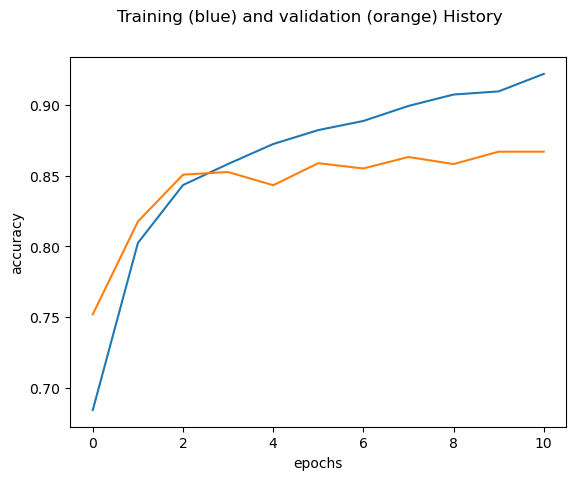

Test Accuracy 86.07397793640493%


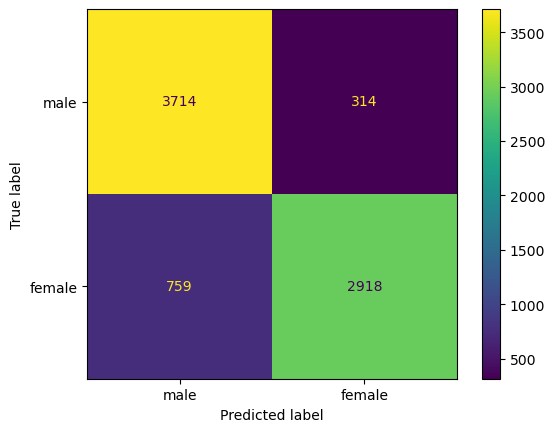

In [13]:
y_pred= convnet.predict(X_test)
y_true=y_test
report(history,y_pred,y_true)

### You should get ~87% test accuracy using a 16000:7350 data split - not bad for a small convnet and ~10 iterations
## But what if we had fewer samples?

- say 500  in total
- and we use 20% for testing
- and 10% for validation  to do early stopping

We'll use the sklearn train_test_split() method to make sure the male/female mix in our subset is roughly the same as in our original data

***and we'll do some memory cleaning along the way***

In [14]:
#delete the bigger Xtrain test etc
del X_train,X_test,y_train,y_test

#num_imgs=500
seed = 12345
_, img_subset,_,label_subset= train_test_split(imgs,y,
                                               test_size=num_imgs,
                                               shuffle=True,stratify=y,
                                               random_state=seed)
X_train,X_test,y_train,y_test= train_test_split(img_subset,label_subset,
                                                test_size=0.2,
                                                shuffle=True,stratify=label_subset,
                                                random_state=seed)
print(f'gender split in training subset {np.unique(y_train[:,0].astype(int),return_counts=True)[1]}')
print(f'gender split in test subset {np.unique(y_test[:,0].astype(int),return_counts=True)[1]}')

gender split in training subset [382 418]
gender split in test subset [ 95 105]


### Retrain a new  model on this smaller dataset

In [15]:
convnet2 = conv_model(num_classes=2)
history= convnet2.fit(X_train,y_train,validation_split=0.125,epochs=max_epochs,batch_size=batchsize, callbacks=early_stopping,verbose=True)
y_pred= convnet2.predict(X_test)

Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4929 - loss: 14.1576 - val_accuracy: 0.5700 - val_loss: 0.6986
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6270 - loss: 0.6576 - val_accuracy: 0.6000 - val_loss: 0.6593
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6913 - loss: 0.6337 - val_accuracy: 0.6700 - val_loss: 0.6174
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6730 - loss: 0.6083 - val_accuracy: 0.6800 - val_loss: 0.5782
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6958 - loss: 0.5848 - val_accuracy: 0.6800 - val_loss: 0.5967
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


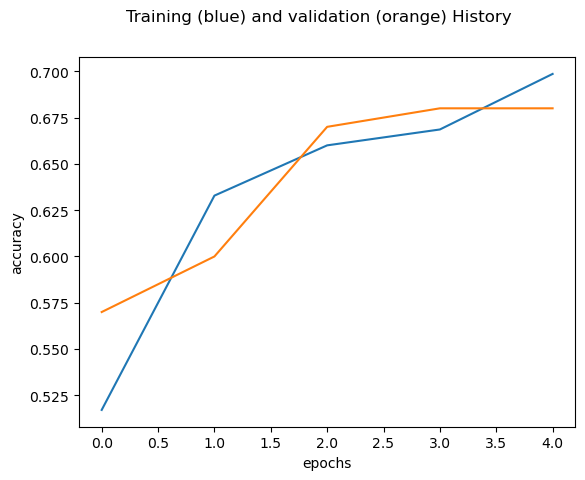

Test Accuracy 63.0%


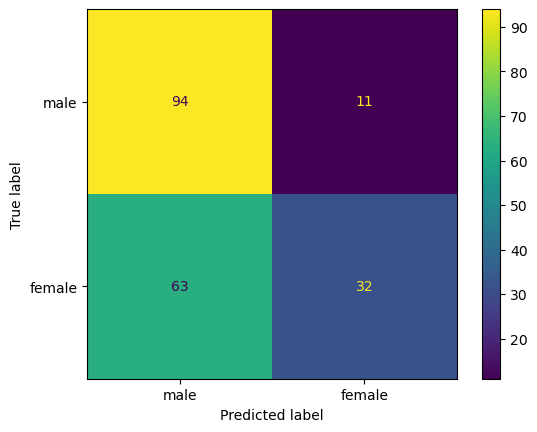

In [16]:
report(history,y_pred,y_test)

### you'll probably see about a twenty percent reduction in mean accuracy, 
- and the accuracy for females is affected most

### Note also that early stopping kicks in around 14 epochs, 
- but accuracy is starting to flatline
- in my experiments it  changing patience to 10 only ran for ~5 more epochs and did not affect accuracy 

## Keras Support for data augmentation
There is a list of preprocessing layers, including data augmentation, and different ways of using them in a workflow in [this Keras guide](https://keras.io/guides/preprocessing_layers/).

For now we will begin by illustrating the effects of some common functions
 - **look up what the parameters mean** 

In [24]:
data_augmentation = [Sequential([keras_layers.RandomFlip(mode='horizontal')]),
                     Sequential([keras_layers.RandomContrast(1)]), 
                     Sequential([keras_layers.RandomRotation(0.05)]),
                     Sequential([keras_layers.RandomZoom(0.5)]),
                     Sequential([keras_layers.RandomTranslation(0.1,0.1)])]
names=['flip','contrast','rotation','zoom','translate']


(-0.5, 47.5, 47.5, -0.5)

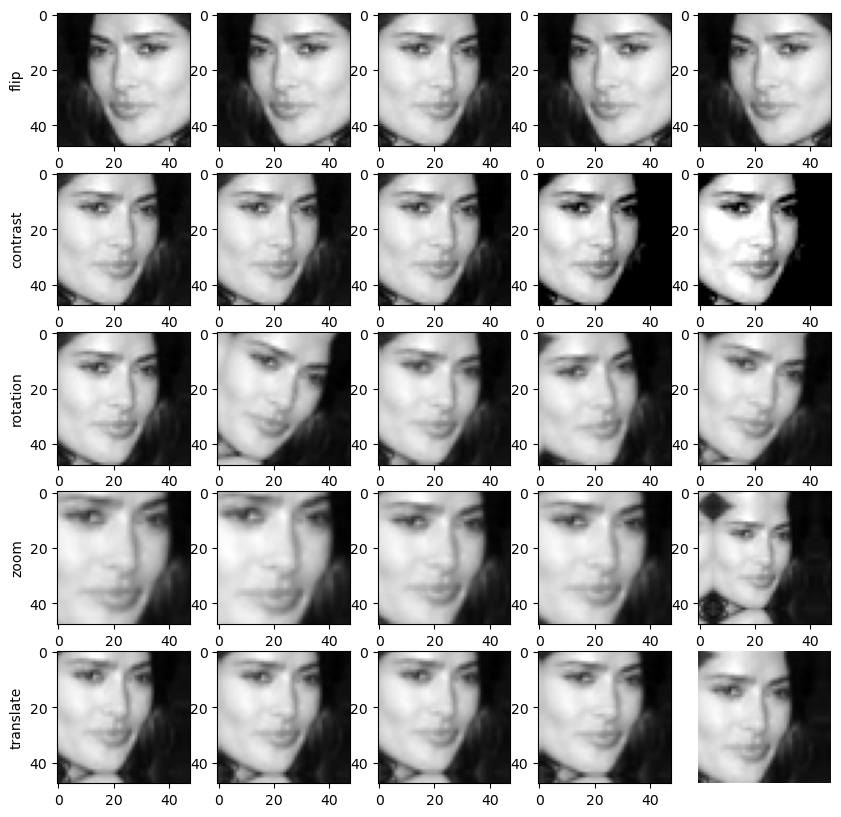

In [25]:
fig,axs= plt.subplots(len(names),5,figsize=(10, 10))
first_image = X_train[0]
for row in range(len(names)):
    axs[row][0].set_ylabel(names[row])
    for col in range(5):
        augmented_image = data_augmentation[row](
        tf.expand_dims(first_image, 0), training=True
        )
        axs[row][col].imshow(augmented_image[0].numpy().astype("int32"),cmap='gray')
plt.axis("off")

# so now to create a pipeline that will be used in training

In [26]:
def get_gender_face_data(seed=12345,num_imgs=1000):
    if (socket.gethostname()=='csctcloud'): #on csctcloud
        datapath="/home/common/datasets"
    elif (socket.gethostname()[0:7]=='jupyter'): #on csctcloud
        datapath="~/shared/datasets"
    else: #machine specific- this is for jim's development
        datapath = "../datasets"
    dataframe = pd.read_csv(datapath+'/utk/teacher_pupil.csv')
    
    imgs = dataframe['pixels'].to_numpy()
    imgs = np.array([x.split(' ') for x in imgs], dtype=float)
    imgs = imgs.reshape(-1,48,48,1).astype(int)
    labels= dataframe['gender'].to_numpy()
    del dataframe
    y = to_categorical(labels,num_classes=2)
    
    _, img_subset,_,label_subset= train_test_split(imgs,y,
                                                   test_size=num_imgs,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=seed)
    X_train,X_test,y_train,y_test= train_test_split(img_subset,label_subset,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=label_subset,
                                                    random_state=seed)
    print(f'gender split in training subset {np.unique(y_train[:,0].astype(int),return_counts=True)[1]}')
    print(f'gender split in test subset {np.unique(y_test[:,0].astype(int),return_counts=True)[1]}')

    return X_train,X_test,y_train,y_test

In [61]:
# make a function that will let us choose which augementations to use
def make_augmenter(flip=True,
                   contrast=True,
                   rotation=True,
                   zoom=True,
                   translation=True):
    augmenter = Sequential()
    #add 'do-nothing' layer in case rest are all false
    augmenter.add(keras_layers.Lambda(lambda x: x))
    #
    if flip:
        print('adding random flip')
        augmenter.add(keras_layers.RandomFlip(mode='horizontal'))
    if contrast:
        print('adding random contrast')
        augmenter.add(keras_layers.RandomContrast(1))
    if rotation:
        print('adding random rotation')
        augmenter.add(keras_layers.RandomRotation(0.05))
    if zoom:
        print('adding random zoom')
        augmenter.add(keras_layers.RandomZoom(0.5))
    if translation:
        print('adding random translation')
        augmenter.add(keras_layers.RandomTranslation(0.1,0.1))
    return augmenter

In [60]:
# Create a tf.data pipeline of augmented images (and their labels)
#this time we have to take out the validation set manually

def get_augmented_data_streams(X_train,y_train,
                               batchsize,
                               data_augmentation,
                               valsplit=0.1):
    
    #get sizes of data- note we rely on it having been shuffled
    split=int(X_train.shape[0] * (1.0-valsplit))
    valsize= int(X_train.shape[0]*valsplit)
    assert  split+valsize ==len(y_train),f"can't split data we don't have {len(y_train)}"
    #then split it up
    x_tr= X_train[:split,:]
    y_tr=y_train[:split]
    x_val= X_train[split:split+valsize,:]
    y_val=y_train[split:split+valsize]
    assert split%batchsize==0,f"training set size {split} must be multiple of batchsize{batchsize}"
    assert valsize%batchsize==0,"validation set size must be multiple of batchsize"

    #this is straigthforward but uses tensorflow data objects
    validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    validation_dataset = validation_dataset.batch(batchsize)

    #training dataset gets augmented after being split into batches
    # using the dataset.map function
    train_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
    train_dataset=train_dataset.shuffle(1000)
    train_dataset=train_dataset.batch(batchsize)
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x,training=True), y))
    
    return train_dataset,validation_dataset

### Now put all the pieces together into a function that can be called in a loop 
Note the only difference is that you might want to increase the patience 
- because we are using different training data each epoch
- so that naturally creates more variability

In [57]:
def run_experiment (flip=False,contrast=False,rotation=False,zoom=False,translation=False,
                    batchsize=50,num_imgs=num_imgs,
                    valsplit=0.125,patience=10):
    
    # run data through the pipeline we have created
    X_train,X_test,y_train,y_test = get_gender_face_data(num_imgs=num_imgs)
    data_augmentation= make_augmenter(flip=flip,contrast=contrast,
                                      rotation=rotation,zoom=zoom,translation=translation)
    train_dataset,val_dataset = get_augmented_data_streams(X_train,y_train, 
                                                           batchsize,data_augmentation,
                                                           valsplit=valsplit)
    
    
    # use our defintion of a conv model
    augmented_cnn = conv_model(num_classes=2)
    early_stopping = EarlyStopping(monitor='val_loss',patience=patience, 
                               min_delta=0.001,
                               mode='min',
                               restore_best_weights=True)
    history= augmented_cnn.fit(train_dataset,
                               epochs=max_epochs,
                               batch_size=batchsize,
                               validation_data=val_dataset, 
                               callbacks=early_stopping,
                               verbose=True)

    y_pred = augmented_cnn.predict(X_test,verbose=0)
    return history, y_pred,y_test
    

## Now we can run our first experiment using data augmentation
 - run it once with everything off, 
 - this is the same setup as we had before so you should get 65% - 70% test accuracy
 - then try turning all the different augmenters on and see how that does  
   **Hint** the accuracy will fluctuate more so you might want to increase the patience from 5 to 10 or 20  
   **Hint 2** depending on what you call a 'fair' comparison, you could also increase max_epochs 
   from the default of 100 we used above
   **Hint 3 ** you may need to change the batch size or validatin data split   
   - this behaviour keeps changing between  versions of keras

In [62]:
#this runs an experiment
#with nothing set to be true this is just a replication of the original convnet training

#reminder of what we had above
max_epochs=100
patience=5
batchsize=50
history,y_pred,y_true= run_experiment(translation=False,
                                      rotation=False,
                                      flip=False,
                                      contrast=True,
                                      zoom=False,
                                      num_imgs=num_imgs,
                                      batchsize=batchsize,
                                      patience=patience)


gender split in training subset [382 418]
gender split in test subset [ 95 105]
adding random contrast
Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4678 - loss: 12.3461 - val_accuracy: 0.6300 - val_loss: 0.6545
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5824 - loss: 0.6679 - val_accuracy: 0.6900 - val_loss: 0.6100
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6374 - loss: 0.6447 - val_accuracy: 0.7000 - val_loss: 0.5751
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7070 - loss: 0.5844 - val_accuracy: 0.6900 - val_loss: 0.5955
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6605 - loss: 0.5996 - val_accuracy: 0.7500 - val_loss: 0.5364
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6557 - loss: 0.6026 - val_accuracy: 0.6200 - val_loss: 0.6591
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7035 - loss: 0.6011 - val_accuracy: 0.7200 - val_loss: 0.5383
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7427 - loss: 0.4772 - val_accuracy: 0.8000 - val_

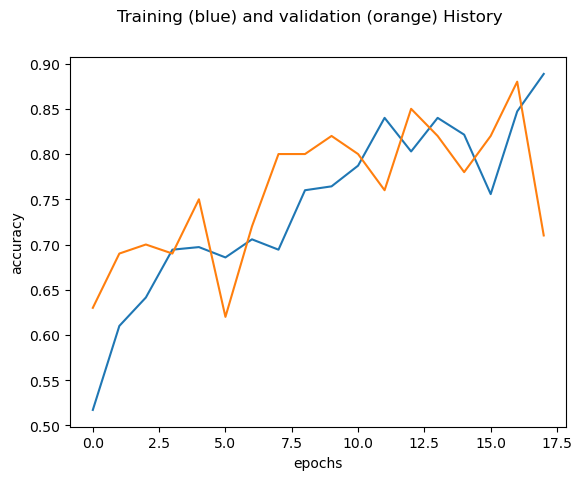

Test Accuracy 72.0%


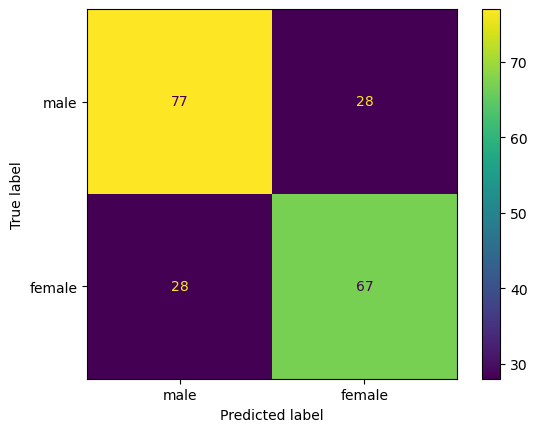

In [63]:
report(history,y_pred,y_true)

## You should see that now the training accuracy is actually often lower than the validation accuracy

- but both are steadily increasing
- you could change the patience value to leave it running longer
- (but on my machine it is using quite a lot of memory)

### With the right set-up you should be able to get  test accuracy quite a bit higher than without augmentation - is this significant?

# Questions to investigate:
1. What is the effect of the random sampling even with no transformations?  
   Try setting all the options to False and do a few train/test runs
2. Which of these are valid and useful transformations for human faces?:
 - translation (horizontal/vertical) shifts
 - rotation
 - horizontal flips
 - vertical flips
 
Do you think it would  make a difference what the task is, i.e. gender recognition vs. recognising a specific person?
 
To do this investigation using appropriate scientific method, treat each of these as a hypothesis to be tested. Take a number of observations (e.g. accuracy of trained model) for each case (e.g. using horizontal flips vs not using horizontal flips) then compare the mean results and use appropriate statistcal tests to determine whether the results are statistically significantly different.

# The main task:

- Use the different pipeline components above to experiment with different sorts of data augmenation available within keras e.g. rotations, zoom,contrast changes,  and vertical/ horizontal flips. There are others available that only require a minor extension to my make_augmenter() function.
- Design an appropriate methodology to evaluate what difference they make singly or in combination to the classification accuracy of the trained system?  
  *Hint*: If you are making several changes to a system you need some way of knowing which have had an effect: [ilustrated in 200 words](https://thaddeus-segura.com/data-aug/)


## The second task:
In the basic method definition of a CNN we had batch normalisation and dropout turned off.  
Try changing the code to see what the effect of the other approaches for reducing over-fitting are in combination with the data augmentation

## The third task:
The approach I used above creates a set of keras layers and pre-processes the data **outside** the model.
 - it is **option 2** in [this blog](https://www.tensorflow.org/tutorials/images/data_augmentation)
 - the alternative is to make the augmentation (or other preprocessing layers) part of your model. 
   described as option 1 in the blog.

To give you more familiarity with working with keras layers, try adapting the convnet() method to put the data augmentation layers inside the model  and see:
- does it affect training speed
- does it affect predictive accuracy?

### class discussion
does data augmentation provide a way of addressing:
- ethical concerns about under-representation of certain groups
- safety concerns for example wrt autonomous vehicles

